In [1]:
import sys
import os
import pandas as pd
import numpy as np
import networkx as nx
from Swing.util.Evaluator import Evaluator
from Swing.util.lag_identification import get_experiment_list, xcorr_experiments, calc_edge_lag
from nxpd import draw
from nxpd import nxpdParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import fisher_exact, linregress, ttest_rel

%matplotlib inline

## Functions!

#### Note: Several of the functions do not pass variables correctly. Code will need to be cleaned if shared

In [29]:
def is_square(n):
    """
    Determine if a number is a perfect square
    :param n: int or float
        The number to check
    :return: Boolean
        Return True if the number is a perfect square
    """
    return np.sqrt(n).is_integer()


def get_factors(n):
    """
    Calculate the factors of a number
    :param n: int
        The number to be factored
    :return: list
        A sorted list of the unique factors from smallest to largest
    """
    factor_list = np.array([[i, n // i] for i in range(1, int(n ** 0.5) + 1) if n % i == 0]).flatten().astype(int)
    return sorted(factor_list.tolist())


def calc_subplot_dimensions(x):
    """
    Calculate the dimensions for a matplotlib subplot object.
    :param x: int
        Number of plots that need to be made
    :return: rows, columns
        The number of rows and columns that should be in the subplot
    """
    if x <= 3:
        rows = x
        columns = 1
    else:
        factor_list = get_factors(x)
        while len(factor_list) <= 2 and not is_square(x):
            x += 1
            factor_list = get_factors(x)
        if is_square(x):
            rows = int(np.sqrt(x))
            columns = int(np.sqrt(x))

        else:
            rows = factor_list[int(len(factor_list)/2-1)]
            columns = factor_list[int(len(factor_list)/2)]

    return rows, columns


def get_true_edges(gold_filename):
    evaluator = Evaluator(gold_filename, '\t')
    edges = evaluator.gs_flat.tolist()
    return edges, evaluator


def get_edge_lags(data_filename):
    df = pd.read_csv(data_filename, sep="\t")
    gene_list = df.columns.values[1:].tolist()
    experiment_list = get_experiment_list(data_filename, 21, 10)
    xcorr_array = xcorr_experiments(experiment_list)
    lags = calc_edge_lag(xcorr_array, gene_list, 0.1, 0.5, timestep=1)
    return lags, df


def get_network_changes(pickle_filename, edge_str='regulator-target', base_str='rank_importance_RF-td_21',
                        shortener_str='rank_importance_', replace=''):
    results_df = pd.read_pickle(pickle_filename)
    edges = results_df[edge_str].values
    baseline = results_df[base_str].values

    diff_df = pd.DataFrame()
    diff_df[edge_str] = edges
    diff_df[('Base_%s' %replace)] = baseline
    rank_df = pd.DataFrame()
    rank_df[edge_str] = edges
    rank_df[('Base_%s' %replace)] = baseline
    for column in results_df.columns:
        if column != edge_str and column != base_str:
            short_name = column.replace(shortener_str, replace)
            diff_df[short_name] = baseline - results_df[column].values
            rank_df[short_name] = results_df[column].values
    diff_df.set_index(['regulator-target'], inplace=True)
    rank_df.set_index(['regulator-target'], inplace=True)
    parameters = set(rank_df.columns[1:].values)
    return diff_df, rank_df, parameters


def get_network_data(goldstandard, timeseries, ignore_self=True):
    # Get true network
    true_edges, evaluator = get_true_edges(goldstandard)
    dg = nx.DiGraph()
    dg.add_edges_from(true_edges)
    
    #Network statistics - deprecated
    #degree = nx.degree_centrality(dg)
    #b_cent = pd.DataFrame.from_dict({k: [v] for k, v in nx.edge_betweenness_centrality(dg).items()}, 'index')
    #b_cent.columns = ['Bcent']
    
    #Calculate edge lags
    edge_lags, data = get_edge_lags(timeseries)
    if ignore_self:
        edge_lags = edge_lags[edge_lags['Parent'] != edge_lags['Child']]
    edge_df = pd.DataFrame(edge_lags['Lag'].values, index=edge_lags['Edge'].values, columns=['Lag'])

    return true_edges, edge_df, data, dg, evaluator

def get_signed_edges(signed):
    df = pd.read_csv(signed, sep='\t', header=None)
    df['regulator-target'] = list(zip(df[0], df[1]))
    df.set_index(['regulator-target'], inplace=True)
    df.drop([0, 1], axis=1, inplace=True)
    df.columns=['sign']
    return df

def calc_scores(ranking_df):
    filtered_ranks = ranking_df.copy()
    filtered_ranks.reset_index(level=0, inplace=True)
    roc = []
    aupr = []
    for c in filtered_ranks.columns[1:]:
        filtered_ranks.sort_values(filtered_ranks.columns[1], inplace=True)
        roc.append(evaluator.calc_roc(filtered_ranks.iloc[:, :2])[2].values[-1])
        aupr.append(evaluator.calc_pr(filtered_ranks.iloc[:, :2])[2].values[-1])
        filtered_ranks.drop(c, axis=1, inplace=True)
    return roc, aupr

def calc_promotion(change_df, columns):
    t_promoted = np.sum(change_df.loc[:, columns].values > 0, axis=0)
    t_demoted = np.sum(change_df.loc[:, columns].values < 0, axis=0)
    t_same = np.sum(change_df.loc[:, columns].values == 0, axis=0)

    t_lagged = change_df[change_df['Lag'] > 0]
    l_promoted = np.sum(t_lagged.loc[:, columns].values > 0, axis=0)
    l_demoted = np.sum(t_lagged.loc[:, columns].values < 0, axis=0)
    l_same = np.sum(t_lagged.loc[:, columns].values == 0, axis=0)
    rows = ['true+', 'true-', 'true=', 'lag+', 'lag-', 'lag=']
    return pd.DataFrame([t_promoted, t_demoted, t_same, l_promoted, l_demoted, l_same], index=rows, columns=columns).T
    

### Compile results

In [33]:
lag_range = {'ml_0': [0, 1], 'ml_1': [0, 2], 'ml_2': [0, 3], 'ml_3': [1, 2], 'ml_4': [1, 4], 'ml_5': [2, 3]}
num_nets = 20
methods = ['Dionesus', 'RF']
replace_dict = {'Dionesus':'D', 'RF':'RF'}
models = ['Yeast', 'Ecoli']
te_change = pd.DataFrame()
te_rank = pd.DataFrame()
roc_df = pd.DataFrame()
pr_df = pd.DataFrame()
for model in models:
    for net in range(1, num_nets+1):
        gold_file = "../data/gnw_insilico/network_data/%s/%s-%i_goldstandard.tsv" % (model, model, net)
        signed_file = gold_file.replace('.tsv', '_signed.tsv')
        data_file = "../data/gnw_insilico/network_data/%s/%s-%i_timeseries.tsv" % (model, model, net)
        true_edges, edge_df, data, dg, evaluator = get_network_data(gold_file, data_file)
        
        signed_edges = get_signed_edges(signed_file)
        
        for ii, method in enumerate(methods):
            short = 'rank_importance_%s' %method
            pickle_file = "%s_net%i_%s_promotion.pkl" % (model, net, method.lower())
            base_str = ('rank_importance_%s-td_21' %method)
            change, ranks, params = get_network_changes(pickle_file, base_str= base_str, 
                                                        shortener_str=short, replace=replace_dict[method])
            
            if ii==0:
                ranks_df = ranks
                change_df = change
            else:
                ranks_df = pd.concat([ranks_df, ranks], axis=1, join='inner')
                change_df = pd.concat([change_df, change], axis=1, join='inner')
        change_df = change_df.reindex_axis(sorted(change_df.columns), axis=1)
        ranks_df = ranks_df.reindex_axis(sorted(ranks_df.columns), axis=1)
        # Calculate the auroc and aupr for each parameter set of the network
        roc_df[model + str(net)], pr_df[model + str(net)]= calc_scores(ranks_df)
        
        full_change = pd.concat([edge_df, change_df], axis=1, join='inner')
        full_rank = pd.concat([edge_df, ranks_df], axis=1, join='inner')
        te_rank = te_rank.append(pd.concat([signed_edges, full_rank[full_rank.index.isin(true_edges)]],
                                                         axis=1, join='inner'))
        te_change = te_change.append(pd.concat([signed_edges, full_change[full_change.index.isin(true_edges)]],
                                               axis=1, join='inner'))

roc_df.index = full_change.columns[1:].values
pr_df.index = full_change.columns[1:].values

In [4]:
# Calculate true edges promoted
conditions = te_change.columns.values[3:]
summary_df = calc_promotion(true_edge_change, conditions)

"""
C table format: [[lagged_promoted, lagged_not_promoted],
                 [not_lagged_promoted, not_lagged_not_promoted]]
"""

c_table = np.array([[summary_df['lag+'], summary_df['lag-']+summary_df['lag=']],
                    [summary_df['true+']-summary_df['lag+'], 
                     summary_df['true-']+summary_df['true=']-summary_df['lag-']-summary_df['lag=']]])

for ii in range(c_table.shape[-1]):
    print(conditions[ii], fisher_exact(c_table[:, :, ii])[1])

# for ii, run in enumerate(conditions):
#     if 'ml' in run:
#         key = run.split('-')[1]
#         min_lag = lag_range[key][0]
#         max_lag = lag_range[key][1]
#         in_range = true_edge_change[(true_edge_change['Lag'] >= min_lag) & (true_edge_change['Lag'] <= max_lag)][[run]]
#         print(run, np.sum(in_range.values > 0)/len(in_range))

D-ml_0 0.0780439923359
D-ml_1 0.0014247694261
D-ml_2 0.000184302874677
D-ml_3 0.000417939470216
D-ml_4 6.26945606545e-06
D-ml_5 4.23675859872e-07
D-td_10 3.88365255067e-06
D-td_15 2.50752945002e-06
D-td_2 0.478171331379
RF-ml_0 0.0167205433469
RF-ml_1 0.0377683068864
RF-ml_2 0.0113720553379
RF-ml_3 0.0200156946768
RF-ml_4 0.0179901273264
RF-ml_5 0.0371920135713
RF-td_10 0.0585445260129
RF-td_15 0.28129988856
RF-td_2 0.0124693150272


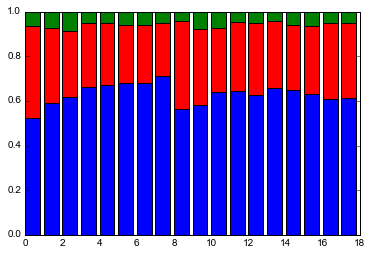

In [5]:
c = ['b', 'r', 'g']
plt.figure()
for ii in range(3,6):
    if ii==3:
        plt.bar(range(len(summary_df)), summary_df.iloc[:, ii]/345, color=c[ii-3])
    else:
        bar_bottom = np.sum(summary_df.iloc[:, 3:ii]/345, axis=1)
        plt.bar(range(len(summary_df)), summary_df.iloc[:, ii]/345, color=c[ii-3], bottom=bar_bottom)
# summary_df.columns[3:]

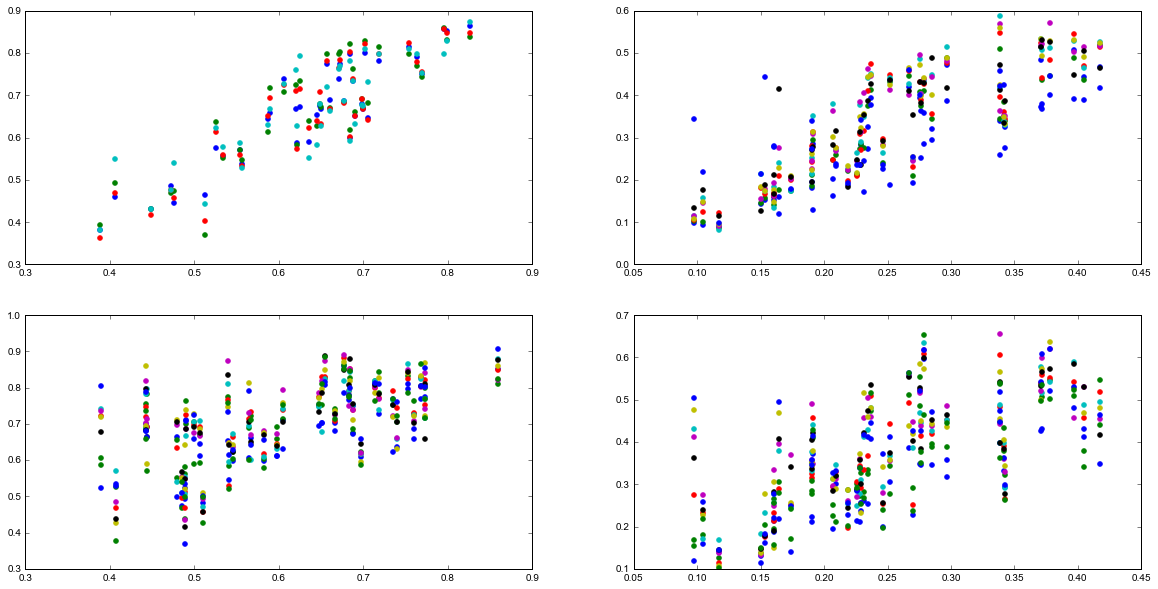

In [6]:
f, axarr = plt.subplots(2, 2, figsize=(20,10))
# axarr[0, 0].plot([0.3, 0.9], [0.3, 0.9], '-', c='0.5', lw=5)
# axarr[1, 1].plot([0.3, 0.9], [0.3, 0.9], '-', c='0.5', lw=5)
for ii in range(2,len(roc_df)):
    m = roc_df.index[ii]
    if 'D' in m:
        roc_pval = ttest_rel(roc_df.iloc[0], roc_df.iloc[ii])[1]
        pr_pval = ttest_rel(pr_df.iloc[0], pr_df.iloc[ii])[1]
        if roc_pval <0.05:
            axarr[0, 0].plot(roc_df.iloc[0], roc_df.iloc[ii], '.', label=m, ms=10)
        if pr_pval <0.05:
            axarr[0, 1].plot(pr_df.iloc[0], pr_df.iloc[ii], '.', label=m, ms=10)
        
    else:
        roc_pval = ttest_rel(roc_df.iloc[1], roc_df.iloc[ii])[1]
        pr_pval = ttest_rel(pr_df.iloc[0], pr_df.iloc[ii])[1]
        if roc_pval < 0.05:
            axarr[1, 0].plot(roc_df.iloc[1], roc_df.iloc[ii], '.', label=m, ms=10)
        if pr_pval <0.05:
            axarr[1, 1].plot(pr_df.iloc[0], pr_df.iloc[ii], '.', label=m, ms=10)


# axarr[0].set_xlabel('Baseline')
# axarr[0].set_ylabel('SWING score')
# axarr[0].legend(loc='best')
# axarr[1].set_xlabel('Baseline')
# axarr[1].set_ylabel('SWING score')
# axarr[1].legend(loc='best')